In [1]:
from _utils import *

folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'
    
num_monomers = 80

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:num_monomers, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:num_monomers, :, :]

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:80, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:80, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp = np.concatenate((esc_maps_interp, cnc_maps_interp), axis=0)
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

# Find lower bound and upper bound of PC1 and PC2 data
pc1_l = all_df['PC1'].min()
pc1_u = all_df['PC1'].max()
pc2_l = all_df['PC2'].min()
pc2_u = all_df['PC2'].max()

pc1_grid = np.linspace(pc1_l, pc1_u, 75)
pc2_grid = np.linspace(pc2_l, pc2_u, 75)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'

# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)  

metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])   

2024-10-13 20:57:51.821474: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-13 20:57:52.419620: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import kmedoids
from sklearn.metrics.pairwise import euclidean_distances

In [4]:
all_maps_pca = pca.transform(all_maps_interp_flat)
diss = euclidean_distances(all_maps_pca)

In [5]:
kmin = 10
kmax = 100

In [7]:
dm = kmedoids.dynmsc(diss, kmax, kmin)
print("Optimal number of clusters according to the Medoid Silhouette:", dm.bestk)
print("Medoid Silhouette over range of k:", dm.losses)
print("Range of k:", dm.rangek)

Optimal number of clusters according to the Medoid Silhouette: 10
Medoid Silhouette over range of k: [0.70134102 0.70008828 0.69569383 0.68980151 0.68725189 0.68432046
 0.46537353 0.46479765 0.46742106 0.46841241 0.46005577 0.45863702
 0.46215968 0.46558601 0.4647853  0.46830796 0.46971074 0.47081894
 0.47117247 0.47045366 0.47183748 0.4692412  0.47021504 0.46878337
 0.46979198 0.47087438 0.47247516 0.47356175 0.47216095 0.47172155
 0.47017029 0.47225258 0.47309119 0.47386412 0.47605465 0.47763905
 0.4789296  0.47916361 0.48024917 0.48153971 0.48048064 0.48184433
 0.48268843 0.47810302 0.47809991 0.47932308 0.48032102 0.479607
 0.4800994  0.48048082 0.48017241 0.48105392 0.48188928 0.48270329
 0.48219727 0.48264171 0.48344521 0.48302654 0.4824238  0.48337431
 0.48348624 0.48428875 0.48470135 0.48498104 0.48578355 0.48617962
 0.48698312 0.48684339 0.48764689 0.48767863 0.48848492 0.48898505
 0.48978855 0.49010775 0.49091125 0.49160636 0.49223654 0.49198678
 0.49222287 0.4923865  0.49299

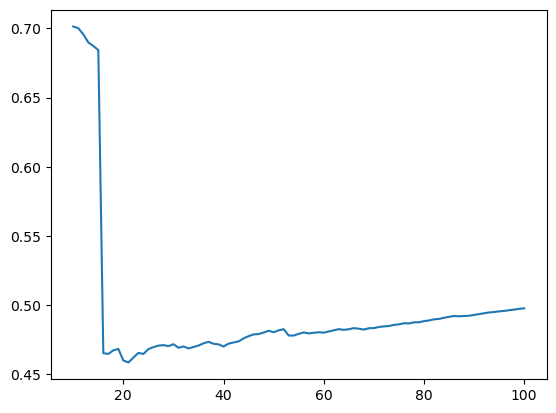

In [9]:
plt.plot(np.arange(kmin, kmax+1), dm.losses)

In [10]:
medoids_idx = dm.medoids

In [11]:
# Get the medoids
medoids_coord = all_maps_pca[medoids_idx]
# Convert these to distance maps representations
medoids_maps = pca.inverse_transform(medoids_coord)

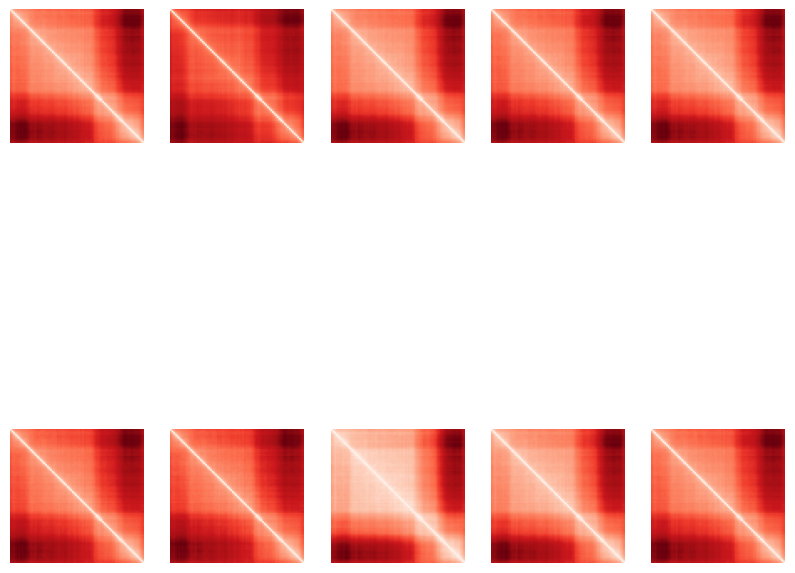

In [12]:
# Plot the heatmap of all medoids
fig, ax = plt.subplots(2, 5, figsize=(10, 10))
for i in range(2):
    for j in range(5):
        ax[i, j].imshow(medoids_maps[i*5+j].reshape(80, 80), cmap='Reds')
        ax[i, j].axis('off')

In [17]:
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)
medoid_df = pd.DataFrame(medoids_coord, columns=['PC1', 'PC2'])
medoid_df['label'] = 'medoids'
all_df = pd.concat([all_df, medoid_df], axis=0)

<Axes: xlabel='PC1', ylabel='PC2'>

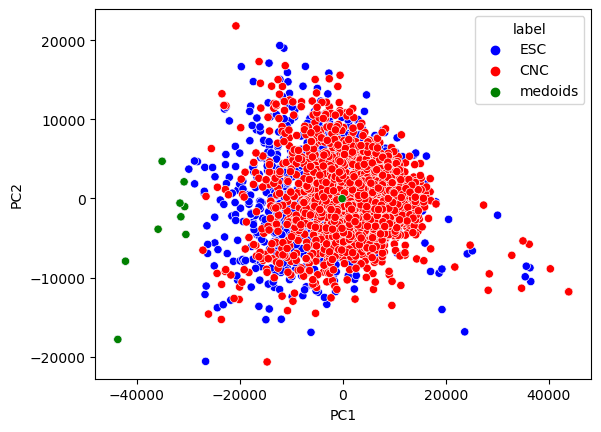

In [16]:
sns.scatterplot(data=all_df, x='PC1', y='PC2', hue='label', palette=['blue', 'red', 'green'])

In [19]:
# Lets try running k-medoid 100 times and see how consistent the results are
md_list = []
for i in tqdm(range(10)):
    md = kmedoids.fasterpam(diss, kmin, max_iter=100, init='random', random_state=None, n_cpu=-1)
    md_list.append(md)

  0%|          | 0/10 [00:00<?, ?it/s]

In [20]:
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)
for i, mds in enumerate(md_list):
    medoids_idx = mds.medoids
    medoids_coord = all_maps_pca[medoids_idx]
    medoid_df = pd.DataFrame(medoids_coord, columns=['PC1', 'PC2'])
    medoid_df['label'] = f'medoids_{i}'
    all_df = pd.concat([all_df, medoid_df], axis=0)

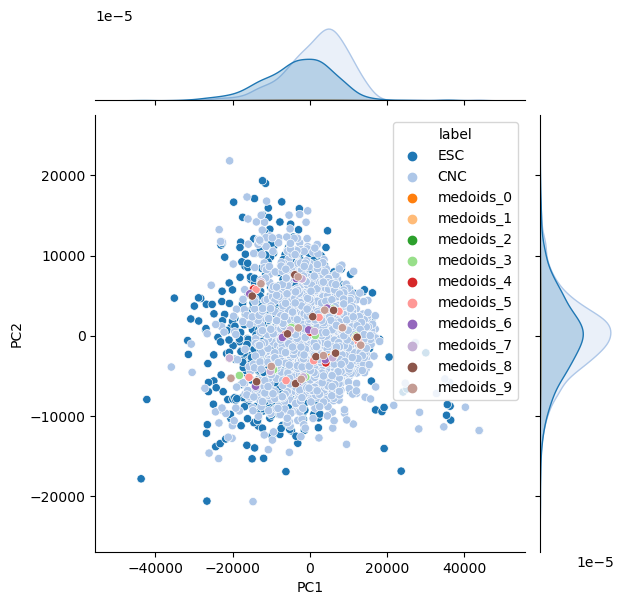

In [23]:
sns.jointplot(data=all_df, x='PC1', y='PC2', hue='label', palette='tab20')

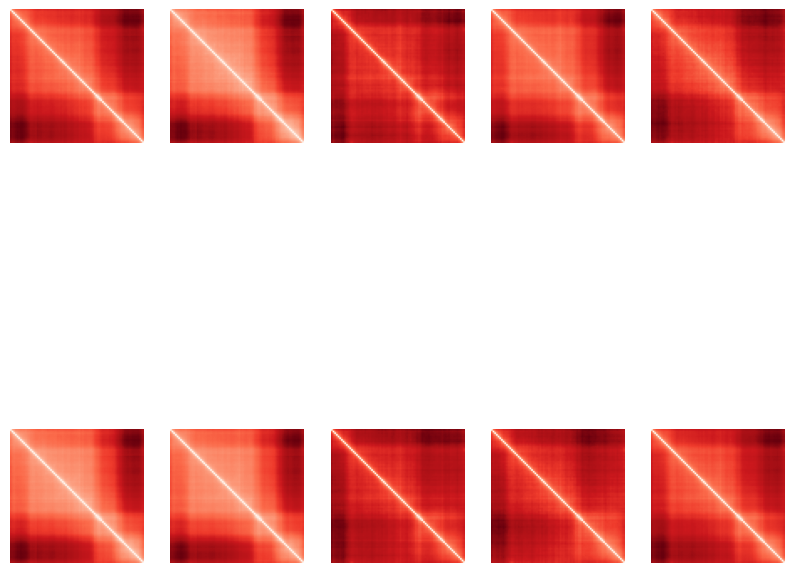

In [25]:
medoid_maps = []
for i, mds in enumerate(md_list):
    medoids_idx = mds.medoids
    medoids_coord = all_maps_pca[medoids_idx]
    medoids_maps = pca.inverse_transform(medoids_coord)
    medoid_maps.append(medoids_maps)



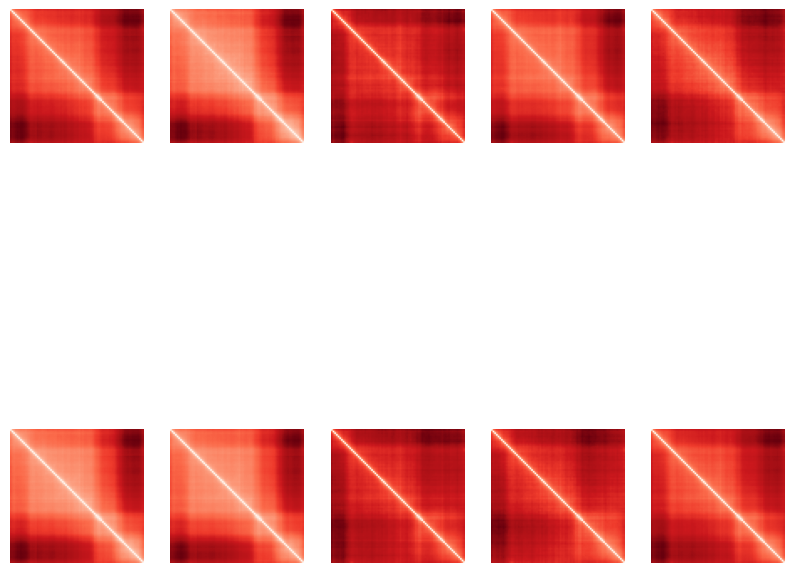

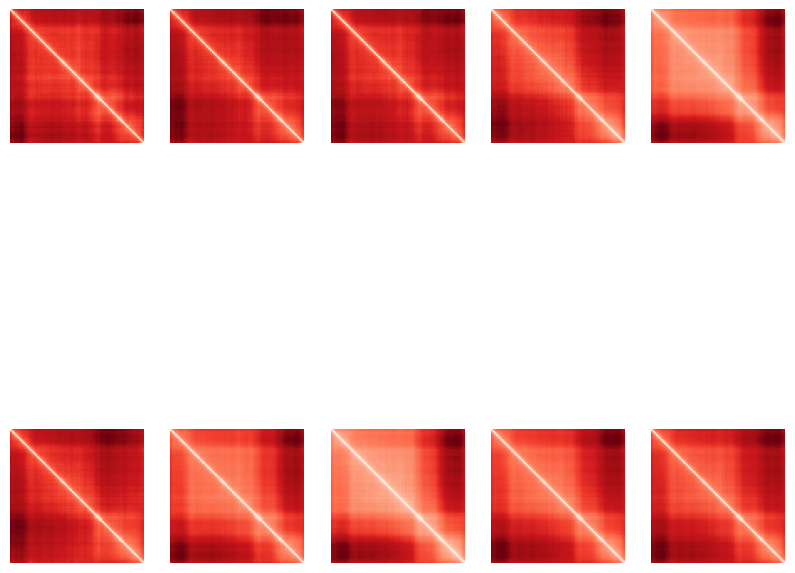

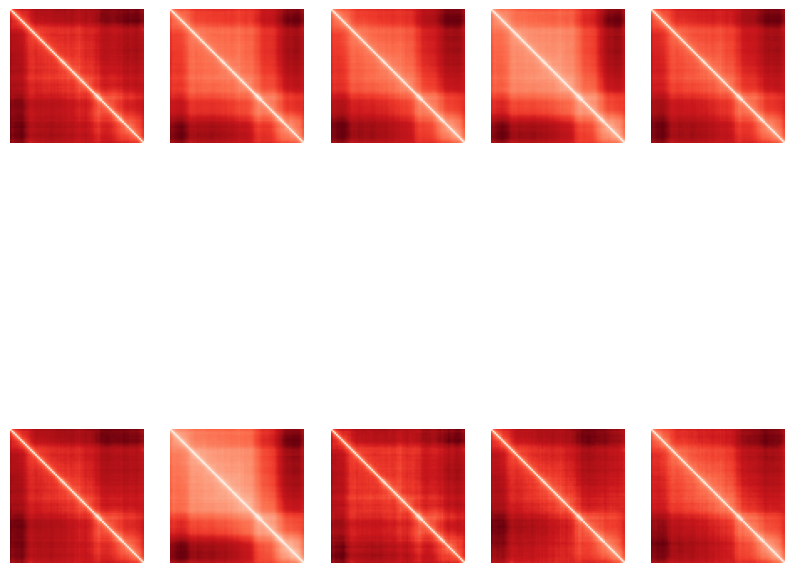

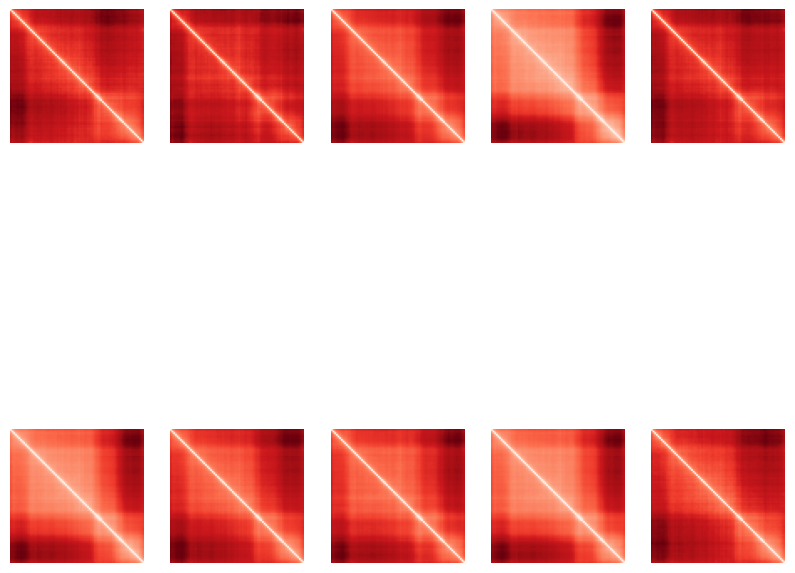

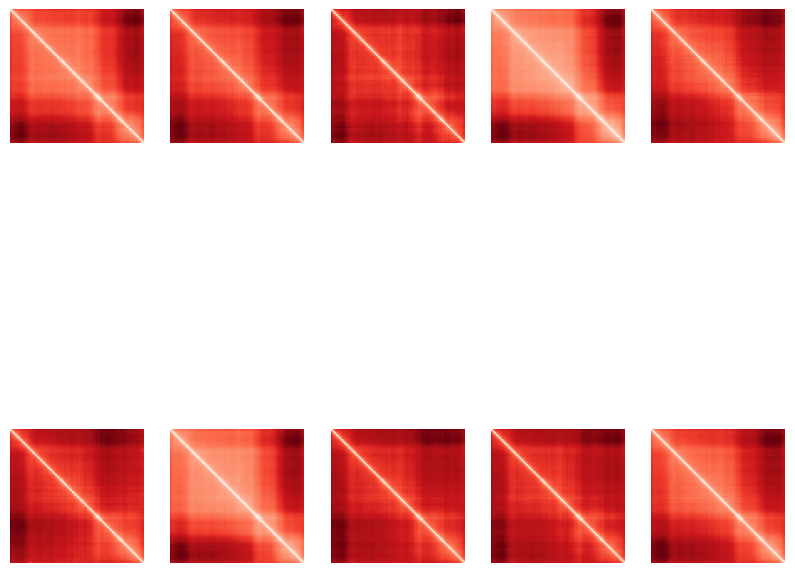

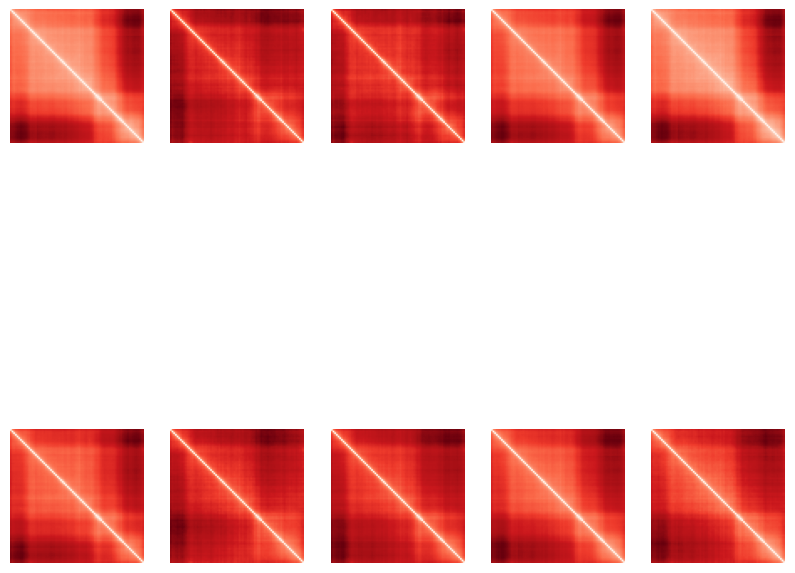

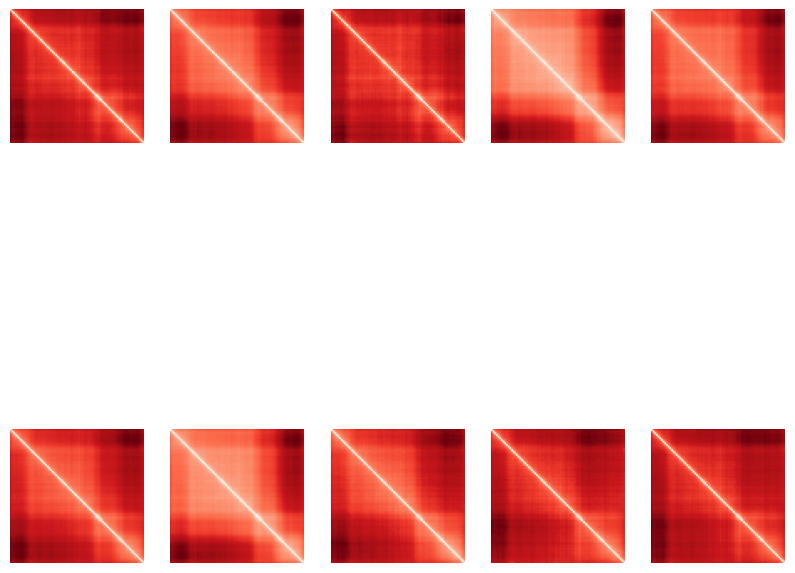

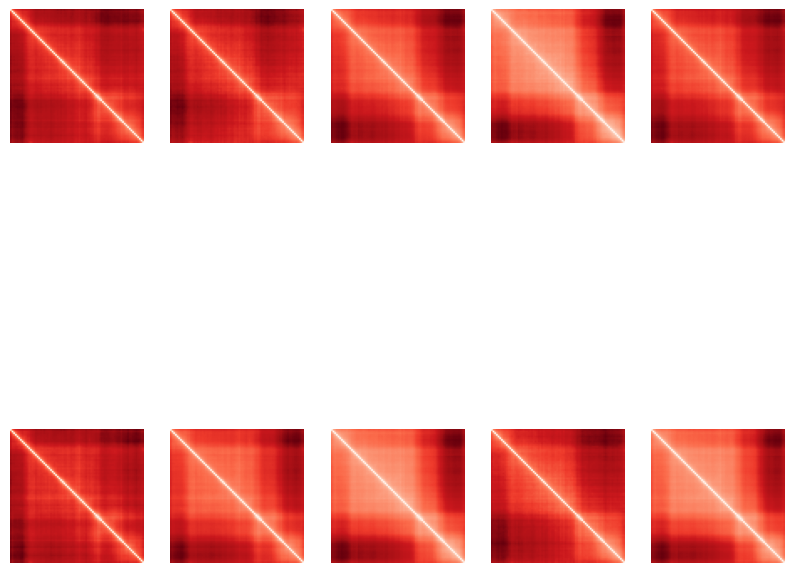

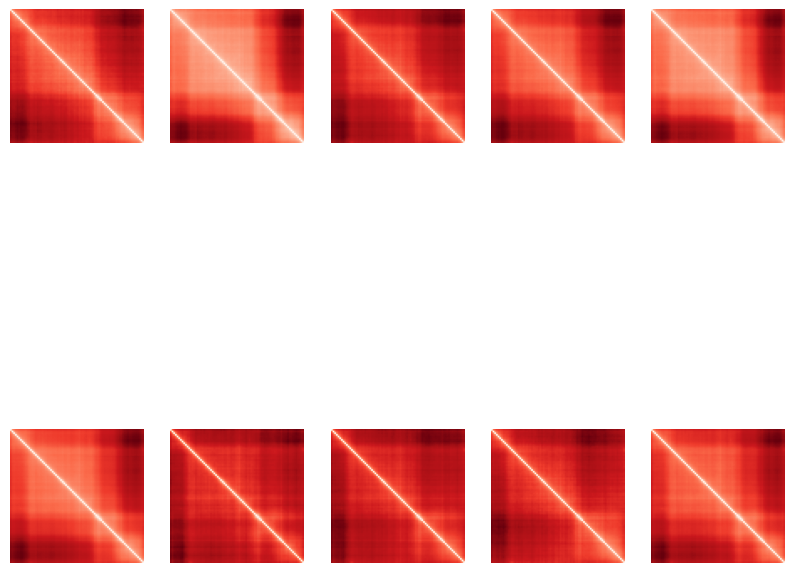

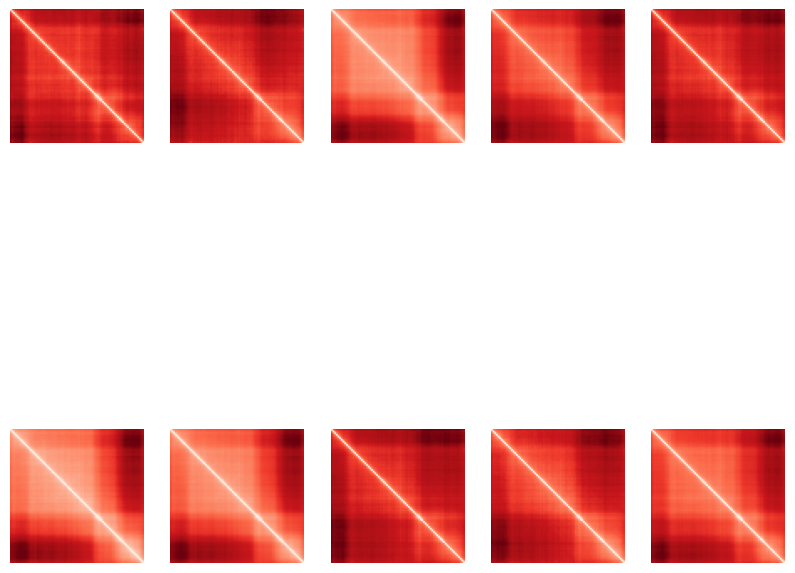

In [26]:
for x in medoid_maps:
    # Plot the heatmap of all medoids
    fig, ax = plt.subplots(2, 5, figsize=(10, 10))
    for i in range(2):
        for j in range(5):
            ax[i, j].imshow(x[i*5+j].reshape(80, 80), cmap='Reds')
            ax[i, j].axis('off')